# Model Development and Training - Customer Service Chatbot

Notebook ini akan fokus pada:
1. Preprocessing data untuk LSTM
2. Membangun arsitektur model LSTM
3. Proses training dengan visualisasi
4. Model checkpointing dan logging

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Atur seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## 1. Load and Preprocess Data

In [45]:
def preprocess_data():
    # Load processed data
    train_df = pd.read_csv('data/processed/train.csv')
    val_df = pd.read_csv('data/processed/validation.csv')
    
    # Hyperparameters
    MAX_NUM_WORDS = 5000
    MAX_SEQUENCE_LENGTH = 100
    
    # Tokenize questions
    question_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
    question_tokenizer.fit_on_texts(train_df['question'].values)
    
    # Convert questions to sequences
    X_train = question_tokenizer.texts_to_sequences(train_df['question'])
    X_val = question_tokenizer.texts_to_sequences(val_df['question'])
    
    # Pad question sequences
    X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
    X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Tokenize answers
    answer_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
    answer_tokenizer.fit_on_texts(train_df['answer'].values)
    
    # Convert answers to sequences
    y_train = answer_tokenizer.texts_to_sequences(train_df['answer'])
    y_val = answer_tokenizer.texts_to_sequences(val_df['answer'])
    
    # Get maximum length of answer sequences
    max_answer_length = max(max(len(seq) for seq in y_train), 
                          max(len(seq) for seq in y_val))
    
    # Pad answer sequences
    y_train = pad_sequences(y_train, maxlen=max_answer_length)
    y_val = pad_sequences(y_val, maxlen=max_answer_length)
    
    # Create an index for the target labels (using first token of each answer)
    y_train_labels = y_train[:, 0]
    y_val_labels = y_val[:, 0]
    
    # Convert to categorical
    answer_vocab_size = len(answer_tokenizer.word_index) + 1
    y_train_cat = tf.keras.utils.to_categorical(y_train_labels, num_classes=answer_vocab_size)
    y_val_cat = tf.keras.utils.to_categorical(y_val_labels, num_classes=answer_vocab_size)
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train_cat.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val_cat.shape}")
    print(f"Question vocabulary size: {len(question_tokenizer.word_index) + 1}")
    print(f"Answer vocabulary size: {answer_vocab_size}")
    print(f"Max answer length: {max_answer_length}")
    
    return (X_train, y_train_cat), (X_val, y_val_cat), question_tokenizer, answer_tokenizer

## 2. Model Architecture

In [46]:
def build_model(vocab_size, embedding_dim, max_length, answer_vocab_size):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # First LSTM layer with return_sequences=True
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        
        # Second LSTM layer
        LSTM(32),
        Dropout(0.3),
        
        # Dense layers
        Dense(16, activation='relu'),
        Dense(answer_vocab_size, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Load and preprocess data
(X_train, y_train), (X_val, y_val), q_tokenizer, a_tokenizer = preprocess_data()

# Model parameters
MAX_NUM_WORDS = 5000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 8
EPOCHS = 30

# Build model
model = build_model(
    vocab_size=len(q_tokenizer.word_index) + 1,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    answer_vocab_size=len(a_tokenizer.word_index) + 1
)

# Print model summary
model.summary()

X_train shape: (61, 100)
y_train shape: (61, 189)
X_val shape: (7, 100)
y_val shape: (7, 189)
Question vocabulary size: 112
Answer vocabulary size: 189
Max answer length: 40


/Users/muhammadkhalidalghifari/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 3. Training Configuration

In [49]:
# Setup directories
model_dir = "models"
checkpoint_dir = os.path.join(model_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        os.path.join(checkpoint_dir, "model_{epoch:02d}.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

## 4. Model Training

In [50]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4164 - loss: 5.1842 - val_accuracy: 1.0000 - val_loss: 4.7578
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9544 - loss: 4.6120 - val_accuracy: 1.0000 - val_loss: 3.9959
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9921 - loss: 3.8845 - val_accuracy: 1.0000 - val_loss: 3.1226
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9921 - loss: 2.8808 - val_accuracy: 1.0000 - val_loss: 2.1106
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9921 - loss: 1.8822 - val_accuracy: 1.0000 - val_loss: 1.1248
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9921 - loss: 1.1047 - val_accuracy: 1.0000 - val_loss: 0.4638
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9921 - loss: 0.4691 - val_accuracy: 1.0000 - val_loss: 0.1795
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9921 - loss: 0.2376 - val_accuracy: 1.0000 - val_loss: 0.0823


## 5. Training Visualization

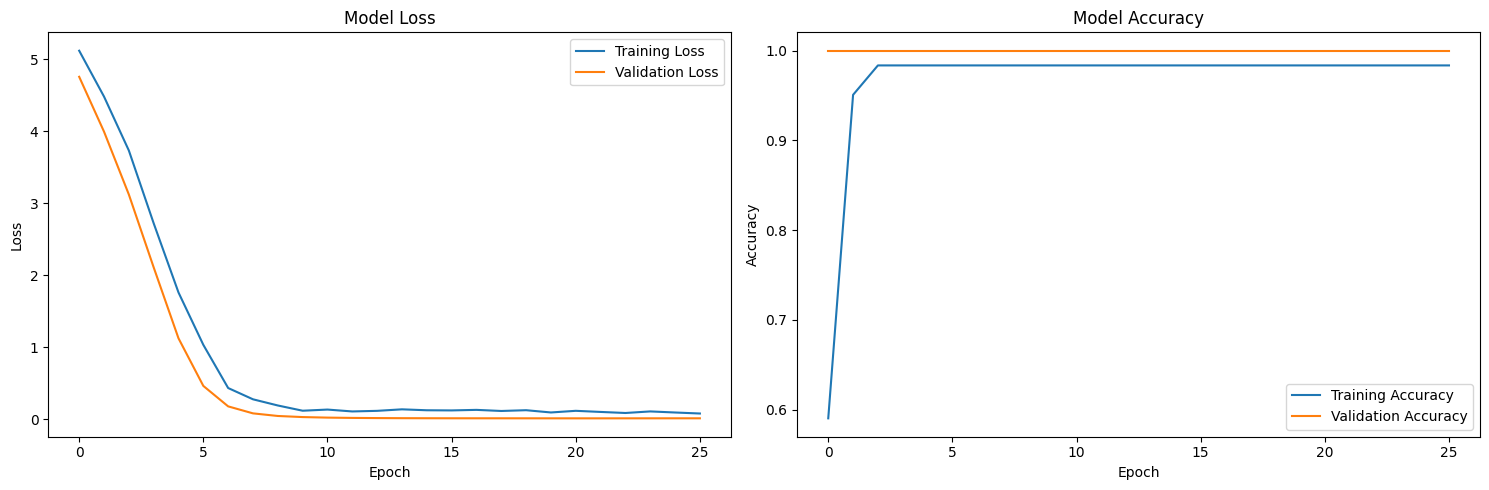


Final Training Metrics:
Loss: 0.0803
Accuracy: 0.9836
Validation Loss: 0.0136
Validation Accuracy: 1.0000


In [51]:
def plot_training_history(history):
    """Plot training metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy plot
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\nFinal Training Metrics:")
    print(f"Loss: {history.history['loss'][-1]:.4f}")
    print(f"Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Plot training history
plot_training_history(history)

## 6. Save Model

In [52]:
# Save model and tokenizers
model.save('models/chatbot_model.h5')

# Save tokenizer configurations
import pickle

with open('models/question_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('models/answer_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_responses, f)

print("Model and tokenizers saved successfully!")

Model and tokenizers saved successfully!
